# Distance and Density-based Outlier Detection Methods

## Distance-based outlier detection

A naive approach:
- consider a data point an outlier if it has distance > $d$ to more than $p$ percent of the data

This actually *does* work in some contexts.

Can you figure any disadvantages?

## Local Outlier Factor
The Local Outlier Factor is based on local densities.

It estimates the density in the neighborhood of a datapoint, and compares it with the average distance to its neighbors.

Based on that ratio a factor, the *local outlier factor*, is assigned to the datapoint.

It is big, if the distance to the nearest neighbors is high in comparison to the average distance within the datapoints neighborhood.

** Advantages**: works for datasets with different densities

** Implementation**:
- available in RapidMiner
- coming to sklearn in version 0.19

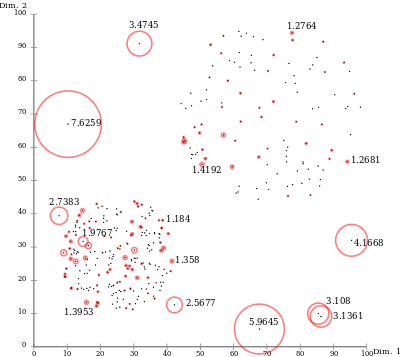*(image source: Wikipedia)*

# Let's generate some data...

...and write a fancy plot function.


We do not need to understand what's going on here. Just know that the output of the functions are a dataset and a plot.

In [1]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
%matplotlib inline

def get_data(outliers_in_train=True):
    # Generate train data
    X1 = 0.2 * np.random.randn(100, 2)
    X2 = 0.5 * np.random.randn(50, 2)
    if outliers_in_train:
        X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
        X_train = np.r_[X1 + 2, X2 - 2, X_outliers]
    else:
        X_train = np.r_[X1 + 2, X2 - 2]
    
    # Generate some regular novel observations
    X1 = 0.2 * np.random.randn(100, 2)
    X2 = 0.5 * np.random.randn(50, 2)
    X_test = np.r_[X1 + 2, X2 - 2]

    # Generate some abnormal novel observations
    X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

    return X_train, X_test, X_outliers

def plot_outliers(clf, X_train, X_test, X_outliers):
    # plot the line, the points, and the nearest vectors to the plane
    xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
    plt.figure(figsize=(16,10))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.title("Novelty Detection")
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
    a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
    plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

    s = 40
    b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s)
    b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s)
    c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s)
    plt.axis('tight')
    plt.xlim((-5, 5))
    plt.ylim((-5, 5))
    plt.legend([a.collections[0], b1, b2, c],
               ["learned frontier", "training observations",
                "new regular observations", "new abnormal observations"],
               loc="upper left",
               prop=matplotlib.font_manager.FontProperties(size=11))
    plt.show()


Automatically created module for IPython interactive environment


## Here's our data...

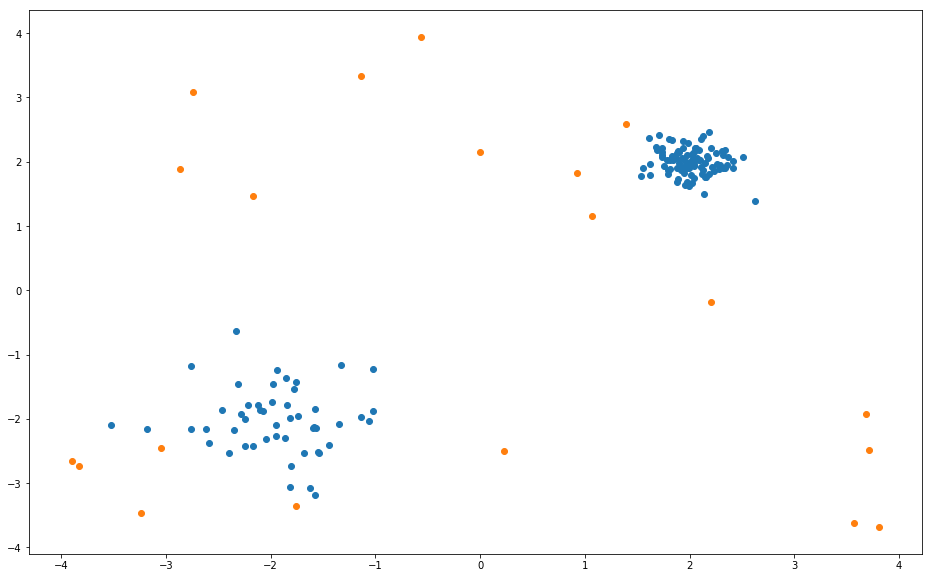

In [2]:
X_train, X_test, X_outliers = get_data(outliers_in_train=False)
plt.figure(figsize=(16,10))
plt.scatter(X_train[:,0], X_train[:,1])
plt.scatter(X_outliers[:,0], X_outliers[:,1]);

Blue is data, orange are outliers.

# The Oneclass SVM

Do you remember the Support Vector Machine from the Introduction to Machine Learning?

The one with the kernel trick and the C parameter... yes, it is normally a classification algorithm for binary classification problems.

Schölkopf has modified it to detect anomalies.

Instead of finding a hyperplane that separates two classes, it finds a hyperplane that wraps the given data as tight as possible... maybe think of it as a hyper potato. Or in another interpretation, it separates the data from the origin. You can read the whole story here: http://rvlasveld.github.io/blog/2013/07/12/introduction-to-one-class-support-vector-machines/

In this notebook, let's just say that a binary SVM can be turned into a oneclass SVM with a small change to the algorithm's optimization function.

**Parameters**
- nu ($\nu$): upper limit of the amount of outliers as fraction of the number of datapoints.
- all the usual kernel parameters. Most commonly you would use an rbf kernel, and need to specify a value for `gamma`.

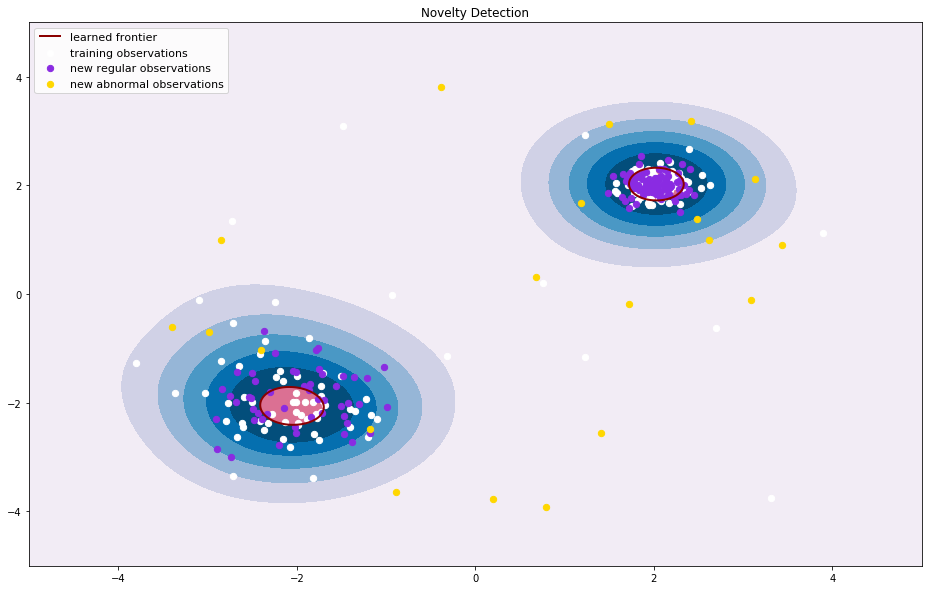

In [3]:
from sklearn.svm import OneClassSVM

X_train, X_test, X_outliers = get_data(outliers_in_train=True)

# fit the model
clf = OneClassSVM(nu=0.5, kernel="rbf", gamma=1)
clf.fit(X_train)
plot_outliers(clf, X_train, X_test, X_outliers);

# The Isolation Forest
The Isolation Forest is basically a Random Forest, that splits the data and tries to isolate every single datapoint in its own leave.

The more splits are necessary to isolate a datapoint, the more dense is the area in which it is located (probably).

By calculated the average path length from the root to the leave with a datapoint, an outlier score can be assigned.

**Parameters**
- `contamination`: expected ratio of outliers
- all the usual random forest parameters

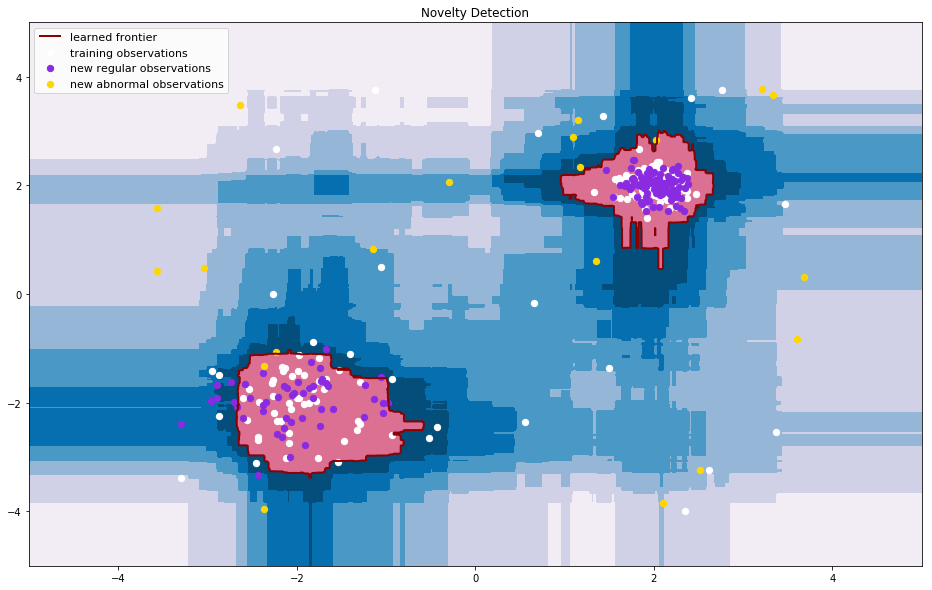

In [12]:
from sklearn.ensemble import IsolationForest

X_train, X_test, X_outliers = get_data(outliers_in_train=True)

# fit the model
clf = IsolationForest(bootstrap=False, n_jobs=-1, contamination=0.1, n_estimators=20)
clf.fit(X_train)
plot_outliers(clf, X_train, X_test, X_outliers)


# Exercise
1. In the code for the oneclass SVM and the Isolation Forest, modify the model parameters and observe how the models change.
1. In the original code, the training data does not contain any outliers. This is probably not very realistic. Try to include the outliers in the training data and see how the models behave. Just set the `outliers_in_train` parameter of the `get_data` function to `True` to get outliers in the training data.
1. *Bonus*: Do LOF, oneclass SVM and Isolation Forest work for the Spiral data? If you like, choose any of them and try it yourself. (for LOF you need to write the data to CSV and load it into RapidMiner until sklearn 0.19 is released)

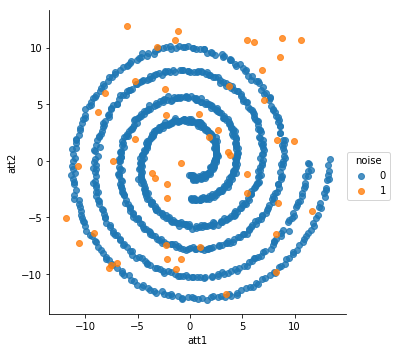

In [11]:
# generate spiral data
import pandas as pd
import numpy as np

df = pd.read_csv('../data/spiral_clusters.csv')
plt.figure(figsize=(6,6))

r = np.random.rand(50,2) * 24 - 12
r = pd.DataFrame(r, columns=['att1', 'att2'])
r['noise'] = 1
noisy_df = df.copy()
noisy_df['noise'] = 0
noisy_df = pd.concat([noisy_df, r])
sns.lmplot(data=noisy_df, x='att1', y='att2', hue='noise', fit_reg=False);

In [6]:
noisy_df.head()

# your code here...

,att1,att2,label,noise
0,0.127883,-3.254566,spiral1,0
1,0.201620,-3.441110,spiral1,0
2,0.135386,-3.389481,spiral1,0
3,0.395188,-3.321379,spiral1,0
4,0.445671,-3.382348,spiral1,0
